# Multi-Model Fusion (late fusion)

In [1]:
import os
import io
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, transforms

In [2]:
PATH = 'dataset'

## 1. Preprocessing data for Metadata MLP

In [3]:
train_metadata_path = os.path.join(PATH, 'train-metadata.csv')

# Load data
train_metadata_unprocessed = pd.read_csv(train_metadata_path, low_memory=False)

### Dataset is highly imbalanced, so to balance it I downsample it to fix it

In [4]:
# Extract all malignant cases (target=1)
positives = train_metadata_unprocessed[train_metadata_unprocessed['target'] == 1]  

# Extract an equal number of benign cases (target=0) to match the number of positives
negatives = train_metadata_unprocessed[train_metadata_unprocessed['target'] == 0]

n_samples = positives.shape[0]
sampled_negatives = negatives.sample(n=n_samples, random_state=42)

In [5]:
# Combine them to get a balanced dataset
train_metadata = pd.concat([sampled_negatives, positives])

### Feature cleaning and encoding

In [6]:
# The following columns are not relevant or are meant to be dropped
# We keep 'isic_id' for alignment purposes (to identify images), and drop it later
to_drop_columns = ['patient_id', 'image_type', 'attribution', 'copyright_license', 'lesion_id']

# "train_only_columns" are columns present only in training, we drop them as they are not needed
train_only_columns = ['iddx_full', 'iddx_1', 'iddx_2','iddx_3', 'iddx_4', 'iddx_5', 
                      'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence']

# Columns to perform one-hot encoding on
one_hot_columns = ['age_approx','sex', 'anatom_site_general', 'tbp_tile_type','tbp_lv_location', 'tbp_lv_location_simple']

# Numerical columns that I will standardize later
numerical_columns = ['clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
                     'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext',
                     'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
                     'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity',
                     'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
                     'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
                     'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z']

In [7]:
# Drop irrelevant columns (but keep isic_id for alignment)
train_metadata = train_metadata.drop(columns=to_drop_columns, errors='ignore')

# Drop train-only columns not needed for inference
train_metadata = train_metadata.drop(columns=train_only_columns, errors='ignore')

### One-hot encoding and standardization

In [8]:
# Identify which columns need one-hot encoding based on what's available in train_metadata
train_one_hot = [c for c in train_metadata.columns if c in one_hot_columns]

# Apply one-hot encoding to the specified columns
train_metadata = pd.get_dummies(train_metadata, columns=train_one_hot)

In [9]:
# Standardize numerical columns
scaler = StandardScaler()
for c in numerical_columns:
    if c in train_metadata.columns:
        train_metadata[c] = scaler.fit_transform(train_metadata[[c]])

### Feature Selection using Correlation and Random Forest

In [10]:
X_full = train_metadata.drop(columns=['target'], errors='ignore')
y_full = train_metadata['target']

In [11]:
print("X_full shape:", X_full.shape)  # should be (393, number_of_features)
print("y_full value counts:\n", y_full.value_counts())

X_full shape: (786, 84)
y_full value counts:
 target
0    393
1    393
Name: count, dtype: int64


In [12]:
# Compute correlation matrix without 'isic_id' since it's not numeric
numeric_df = train_metadata.drop(columns=['isic_id'], errors='ignore')
correlation_matrix = numeric_df.corr()

# Identify features strongly correlated with the target
target_correlation = correlation_matrix['target'].abs().sort_values(ascending=False)

In [13]:
# Using Random Forest to find feature importances
X_for_rf = X_full.drop(columns=['isic_id'], errors='ignore')  # Don't use isic_id in RF
rf_model = RandomForestClassifier(random_state=26)
rf_model.fit(X_for_rf, y_full)
feature_importances = pd.Series(rf_model.feature_importances_, index=X_for_rf.columns).sort_values(ascending=False)

In [14]:
# Select top correlated and top RF importance features
correlated_features = target_correlation[target_correlation >= 0.05].index.drop('target')
rf_features = feature_importances.head(15).index
top_features = correlated_features.union(rf_features)

In [15]:
# Ensure 'isic_id' is included for alignment, even if not a top feature
top_features_list = list(top_features)
if 'isic_id' not in top_features_list:
    top_features_list.append('isic_id')

### Split into TRAIN-VAL-TEST

Here I split the balanced dataset into local train/val/test sets, i.e. - 
80% training
10% validation
10% testing approximately

In [16]:
# First, split 10% for test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_full, y_full, 
    test_size=0.1,
    stratify=y_full, 
    random_state=42
)

In [17]:
# Now split the remaining 90% into approx 11.1% val (which is about 10% of original total),
# leaving approx 80% train. test_size=0.111111 of 90% ~ 10% of original total.

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.111111,
    stratify=y_temp,
    random_state=42
)

In [18]:
print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

Train size: 628
Val size: 79
Test size: 79


### Using Only the Selected Top Features

Now that the splits are redy, I want to reduce to top_features only.
'isic_id' was included in top_features_list for alignment, so after selecting top features, I will drop 'isic_id' before feeding into the model.

In [19]:
X_train = X_train[top_features_list].copy()
X_val = X_val[top_features_list].copy()
X_test = X_test[top_features_list].copy()

In [20]:
# Extract and store isic_ids (for image alignment or other multimodal steps)
train_isic_ids = X_train['isic_id'].astype(str)
val_isic_ids = X_val['isic_id'].astype(str)
test_isic_ids = X_test['isic_id'].astype(str)

In [21]:
# Drop isic_id column
X_train = X_train.drop('isic_id', axis=1, errors='ignore')
X_val = X_val.drop('isic_id', axis=1, errors='ignore')
X_test = X_test.drop('isic_id', axis=1, errors='ignore')

In [22]:
# Reset indices - This will ensure that X_train.iloc[idx] and X_train.loc[idx] refer to the same rows and start at 0
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
train_isic_ids = train_isic_ids.reset_index(drop=True)

X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
val_isic_ids = val_isic_ids.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
test_isic_ids = test_isic_ids.reset_index(drop=True)

In [23]:
# Now convert to float
X_train = X_train.astype(float)
X_val = X_val.astype(float)
X_test = X_test.astype(float)
y_train = y_train.astype(float)
y_val = y_val.astype(float)
y_test = y_test.astype(float)

In [24]:
# Convert Data to Tensors for Model Input
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

### PyTorch dataset class for metadata

In [25]:
class metadataDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [26]:
# Create datasets and dataloaders for train-val-test
train_metadata_dataset = metadataDataset(X_train_tensor, y_train_tensor)
val_metadata_dataset = metadataDataset(X_val_tensor, y_val_tensor)
test_metadata_dataset = metadataDataset(X_test_tensor, y_test_tensor)

train_meta_loader = DataLoader(train_metadata_dataset, batch_size=16, shuffle=True)
val_meta_loader = DataLoader(val_metadata_dataset, batch_size=16, shuffle=False)
test_meta_loader = DataLoader(test_metadata_dataset, batch_size=16, shuffle=False)

## 2. Pre-processing Data for Images (and Aligning by isic_id)

In [27]:
train_image_path = os.path.join(PATH, 'train-image.hdf5')
input_size = 224

In [28]:
# Transformations for training images
transformTrain = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

#Transformations for validation/test images
transformValTest = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [29]:
# PyTorch Dataset class for images alone (no metadata)
class isicDatasetImageOnly(Dataset):
    def __init__(self, hdf5_path, isic_ids, labels, transform=None):
        self.hdf5_path = hdf5_path
        self.isic_ids = isic_ids.reset_index(drop=True) # ensure sequential indexing
        self.labels = labels.reset_index(drop=True)     # ensure labels align with isic_ids
        self.transform = transform

    def __len__(self):
        return len(self.isic_ids) # Length is the number of images (equal to number of isic_ids).

    def __getitem__(self, idx):
        
        # Get the isic_id and label for this index
        isic_id = self.isic_ids.iloc[idx]
        label = self.labels.iloc[idx]
        
        # Open HDF5 file and read the image bytes associated with this isic_id
        with h5py.File(self.hdf5_path, 'r') as hdf5_file:
            bytes_img = hdf5_file[isic_id][()]
            image = Image.open(io.BytesIO(bytes_img)).convert('RGB')
            
        if self.transform:
            image = self.transform(image)
        return image, label

In [30]:
# Create Datasets for train-val-test (image-only)
train_imageDataset = isicDatasetImageOnly(train_image_path, train_isic_ids, y_train, transformTrain)
val_imageDataset = isicDatasetImageOnly(train_image_path, val_isic_ids, y_val, transformValTest)
test_imageDataset = isicDatasetImageOnly(train_image_path, test_isic_ids, pd.Series(np.zeros(len(test_isic_ids))), transformValTest)

train_image_loader = DataLoader(train_imageDataset, batch_size=16, shuffle=True)
val_image_loader = DataLoader(val_imageDataset, batch_size=16, shuffle=False)
test_image_loader = DataLoader(test_imageDataset, batch_size=16, shuffle=False)

## 3. Combined Multimodal Dataset (Metadata + Images)

Before creating a multimodal dataset, I created dictionaries mapping each isic_id to its metadata features.

In [31]:
# train_meta_dict, val_meta_dict, and test_meta_dict map each isic_id to its row of selected metadata features (numpy array).
train_meta_dict = {iid: X_train.loc[idx].values 
                    for idx, iid in enumerate(train_isic_ids)}
val_meta_dict = {iid: X_val.loc[idx].values 
                  for idx, iid in enumerate(val_isic_ids)}
test_meta_dict = {iid: X_test.loc[idx].values 
                   for idx, iid in enumerate(test_isic_ids)}

isicMultimodalDataset: a Dataset that returns (image, metadata features, label) tuples.

It uses both:
- hdf5 file for images (like isicDatasetImageOnly)
- meta_dict for metadata features

In [32]:
class isicMultimodalDataset(Dataset):
    def __init__(self, hdf5_path, isic_ids, labels, meta_dict, transform=None):
        self.hdf5_path = hdf5_path
        self.isic_ids = isic_ids.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.meta_dict = meta_dict  # dictionary {isic_id: feature_vector}
        self.transform = transform

    def __len__(self):
        return len(self.isic_ids) # Length is the number of samples (consistent with isic_ids)

    def __getitem__(self, idx):
         
        # Retrieve the isic_id and corresponding label and metadata
        isic_id = self.isic_ids.iloc[idx]
        label = self.labels.iloc[idx]

        # Get the metadata features for this isic_id
        meta_features = self.meta_dict[isic_id]
        # Convert metadata to a float32 tensor
        meta_features = torch.tensor(meta_features, dtype=torch.float32)

        # Load the image from the HDF5 file
        with h5py.File(self.hdf5_path, 'r') as hdf5_file:
            bytes_img = hdf5_file[isic_id][()]
            image = Image.open(io.BytesIO(bytes_img)).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Return (image, metadata_features, label) tuple
        return image, meta_features, torch.tensor(label, dtype=torch.float32)

In [33]:
# Create Multimodal Datasets and  - combined both image and metadata for train, val, and test sets.
train_mm_dataset = isicMultimodalDataset(train_image_path, train_isic_ids, y_train, train_meta_dict, transformTrain)
val_mm_dataset = isicMultimodalDataset(train_image_path, val_isic_ids, y_val, val_meta_dict, transformValTest)
test_mm_dataset = isicMultimodalDataset(train_image_path, test_isic_ids, y_test, test_meta_dict, transformValTest)

train_mm_loader = DataLoader(train_mm_dataset, batch_size=16, shuffle=True)
val_mm_loader = DataLoader(val_mm_dataset, batch_size=16, shuffle=False)
test_mm_loader = DataLoader(test_mm_dataset, batch_size=16, shuffle=False)

## 4. Define Models (MLP for Metadata, ResNet for Images, Late Fusion)

### MLPModel: To process metadata features
The metadata features are passed through a stack of linear layers (fully connected layers) with:
- Batch normalization: To stabilize and speed up training by normalizing layer outputs.
- ReLU activation: To introduce nonlinearity, helping the model learn complex patterns.

This architecture outputs a 32-dimensional feature vector (embedding) for each input sample.

In [34]:
class MLPModel(nn.Module):
    def __init__(self, input_dim):
        super(MLPModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128), # Fully connected layer mapping input_dim -> 128
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),  # 128 -> 64
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),  # 64 -> 32
            nn.BatchNorm1d(32),
            nn.ReLU()
        )

    def forward(self, x):
        return self.fc(x)  # Output: A 32-dimensional embedding representing the metadata

# X_train contains the preprocessed metadata; number of columns = number of features
mlp_input_dim = X_train.shape[1]

 # Instantiate the MLP model
mlp_model = MLPModel(mlp_input_dim)

### ResNet-18 model: To process image data

In [35]:
# Pretrained models are initialized with weights trained on ImageNet, enabling transfer learning
resnet = models.resnet18(pretrained=True)

# Freeze all ResNet parameters to prevent them from being updated during training
# This leverages the pretrained features without modifying them
for param in resnet.parameters():
    param.requires_grad = False

/pfs/lustref1/flash/project_465001560/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/pfs/lustref1/flash/project_465001560/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
# Modify the ResNet model to remove its final fully connected layer (classifier)
# Instead of producing a class score, the ResNet now outputs a 512-dimensional feature vector (penultimate layer)

resnet.fc = nn.Identity()   # Replace the final layer with an identity layer (pass-through)

# output a 512-dim embedding

### Late Fusion model: To combine embeddings from MLP and ResNet models
Late fusion involves combining the outputs (embeddings) of both models at a late stage in the architecture.

In [37]:
class LateFusionModel(nn.Module):
    def __init__(self, mlp, resnet, mlp_output_dim=32, resnet_output_dim=512):
        super(LateFusionModel, self).__init__()
        
        # mlp: the MLP model for metadata
        self.mlp = mlp

        # resnet: the ResNet model for images
        self.resnet = resnet

        # Define layers for fusion
        self.fc_fusion = nn.Sequential(
            nn.Linear(mlp_output_dim + resnet_output_dim, 64), # Combine MLP and ResNet embeddings (32 + 512 -> 64)
            nn.ReLU(),                                         # ReLU activation after combination
            nn.Linear(64, 1),                                  # Output layer (maps 64 -> 1 for binary classification)
            nn.Sigmoid()
        )
    def forward(self, image, meta):
        meta_emb = self.mlp(meta)                      # MLP to generate a 32-dimensional embedding
        img_emb = self.resnet(image)                   # ResNet to generate a 512-dimensional embedding
        fused = torch.cat([meta_emb, img_emb], dim=1)  # Concatenate the two embeddings along the feature dimension (dim=1)
        out = self.fc_fusion(fused)
        return out

In [38]:
print("PyTorch HIP Version:", torch.version.hip)  # ROCm version
print("Is CUDA available?:", torch.cuda.is_available())
print("CUDA Device Name:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch HIP Version: 5.4.22803-474e8620
Is CUDA available?: True
CUDA Device Name: AMD Instinct MI250X


### Instantiate the LateFusionModel by passing the MLP and ResNet models

In [39]:
model = LateFusionModel(mlp_model, resnet).to(device)

In [40]:
# Compute class weights to handle class imbalance in the dataset.
# This calculates weights inversely proportional to the class frequencies in the training data.

y_array = y_train
class_weights = compute_class_weight('balanced', classes=np.unique(y_array), y=y_array)

# Convert class weights to a tensor and move them to the computation device
weightsTensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [41]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## 5. Train the Late-Fusion Model

In [42]:
def train_fusion_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict()) # Save the best-performing model weights

    # Lists to store history of loss and accuracy for training and validation
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-'*10)

        # Train phase
        model.train()
        running_loss = 0.0      # Accumulates loss for the epoch
        running_corrects = 0    # Accumulates correct predictions for accuracy
        total = 0
        for images, metas, labels in train_loader:
            images = images.to(device)
            metas = metas.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, metas).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate training loss (scaled by batch size)
            running_loss += loss.item() * images.size(0)
            
            # Convert outputs to binary predictions (threshold = 0.5)
            preds = (outputs > 0.5).float()
            
            # Count correct predictions
            running_corrects += (preds == labels).sum().item()
            total += labels.size(0)

        # Compute average loss and accuracy for this epoch
        epoch_train_loss = running_loss / total
        epoch_train_acc = running_corrects / total

        # Store in history
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        # Validation phase
        model.eval()
        running_loss = 0.0     # Reset loss accumulation for validation
        running_corrects = 0   # Reset correct prediction counter
        total = 0
        with torch.no_grad():  # Disable gradient computation for validation
            for images, metas, labels in val_loader:
                images = images.to(device)
                metas = metas.to(device)
                labels = labels.to(device)

                outputs = model(images, metas).squeeze()
                loss = criterion(outputs, labels)

                # Accumulate validation loss (scaled by batch size)
                running_loss += loss.item() * images.size(0)

                # Convert outputs to binary predictions
                preds = (outputs > 0.5).float()

                 # Count correct predictions
                running_corrects += (preds == labels).sum().item()
                total += labels.size(0)

        # Compute average loss and accuracy for validation
        epoch_val_loss = running_loss / total
        epoch_val_acc = running_corrects / total

        # Store in history
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
        print()
        
        # Save the model weights if this epoch has the best validation accuracy so far
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    print("Training complete. Best Val Acc: {:.4f}".format(best_acc))

    return model, (train_loss_history, val_loss_history, train_acc_history, val_acc_history)

### Train the fusion model and retrieve history

In [43]:
model, history = train_fusion_model(model, train_mm_loader, val_mm_loader, criterion, optimizer, num_epochs=30)
train_loss_history, val_loss_history, train_acc_history, val_acc_history = history

Epoch 1/30
----------
Train Loss: 0.6908, Train Acc: 0.5175
Val Loss: 0.6490, Val Acc: 0.6203

Epoch 2/30
----------
Train Loss: 0.6541, Train Acc: 0.6481
Val Loss: 0.6324, Val Acc: 0.6709

Epoch 3/30
----------
Train Loss: 0.6334, Train Acc: 0.6831
Val Loss: 0.6017, Val Acc: 0.6582

Epoch 4/30
----------
Train Loss: 0.6207, Train Acc: 0.6704
Val Loss: 0.5927, Val Acc: 0.7595

Epoch 5/30
----------
Train Loss: 0.5994, Train Acc: 0.7182
Val Loss: 0.5614, Val Acc: 0.7342

Epoch 6/30
----------
Train Loss: 0.5758, Train Acc: 0.7166
Val Loss: 0.5534, Val Acc: 0.7468

Epoch 7/30
----------
Train Loss: 0.5596, Train Acc: 0.7309
Val Loss: 0.5286, Val Acc: 0.7722

Epoch 8/30
----------
Train Loss: 0.5485, Train Acc: 0.7293
Val Loss: 0.5081, Val Acc: 0.7595

Epoch 9/30
----------
Train Loss: 0.5226, Train Acc: 0.7596
Val Loss: 0.4937, Val Acc: 0.8101

Epoch 10/30
----------
Train Loss: 0.4978, Train Acc: 0.7755
Val Loss: 0.4629, Val Acc: 0.7848

Epoch 11/30
----------
Train Loss: 0.5083, Train 

## 6. Visualisation Training and Validation Metrics

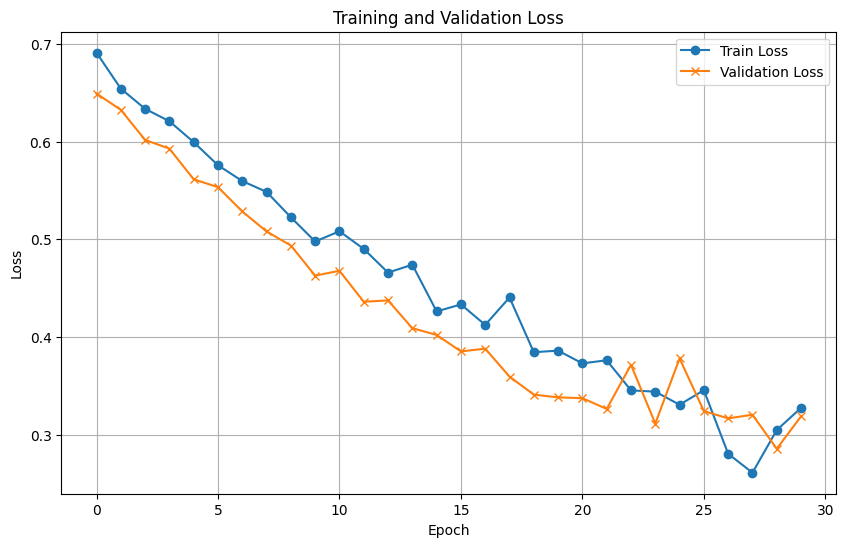

In [44]:
# Training and Validation Loss
plt.figure(figsize=(10,6))
plt.plot(train_loss_history, label='Train Loss', marker='o')
plt.plot(val_loss_history, label='Validation Loss', marker='x')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

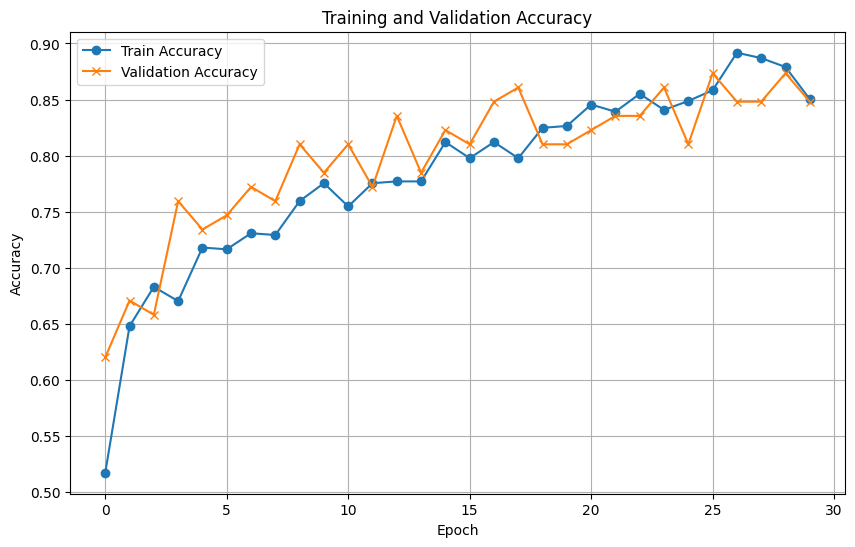

In [45]:
# Training and Validation Accuracy
plt.figure(figsize=(10,6))
plt.plot(train_acc_history, label='Train Accuracy', marker='o')
plt.plot(val_acc_history, label='Validation Accuracy', marker='x')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

## Evaluate Model on Test Data

In [46]:
# Evaluate on test set
model.eval()

LateFusionModel(
  (mlp): MLPModel(
    (fc): Sequential(
      (0): Linear(in_features=51, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=32, bias=True)
      (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
    )
  )
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(

In [47]:
# Store ground truth labels
y_true = []

# Store predictions
y_pred = []

with torch.no_grad():
    for images, metas, labels in test_mm_loader:
        images = images.to(device)
        metas = metas.to(device)
        labels = labels.to(device)
        
        # Get model predictions
        outputs = model(images, metas).squeeze()
        preds = (outputs > 0.5).float()

        # Append ground truth and predictions to lists
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

In [48]:
# Compute evaluation metrics
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='binary')
test_recall = recall_score(y_true, y_pred, average='binary')
test_f1 = f1_score(y_true, y_pred, average='binary')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.8608
Test Precision: 0.8333
Test Recall: 0.8974
Test F1 Score: 0.8642


In [49]:
# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.82      0.86        40
         1.0       0.83      0.90      0.86        39

    accuracy                           0.86        79
   macro avg       0.86      0.86      0.86        79
weighted avg       0.86      0.86      0.86        79



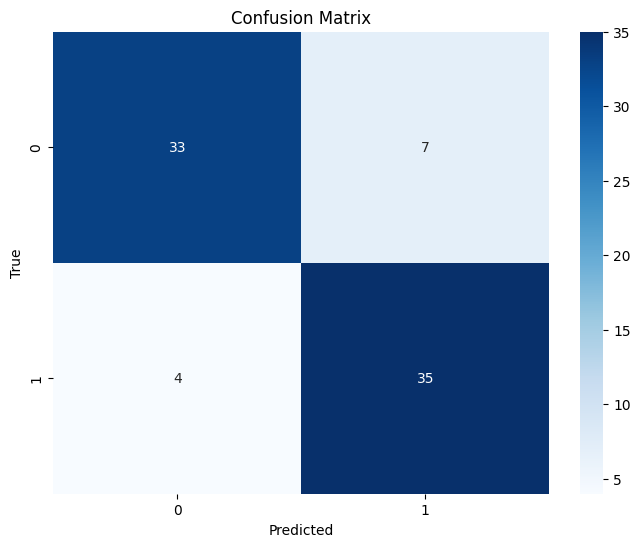

In [50]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()